**LSTM experiments with average dataset (dat_files)**

Notebook contains experiments ran with an LSTM model that has been fine-tuned. Experiments were ran with the raw data then data after it has been scaled.
NOTE: LSTM trains much slower than CNN Model.

**Mount Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Switch to directory with dat files**

In [5]:
%cd drive/My\ Drive/dat_files

/content/drive/.shortcut-targets-by-id/1uvJj8GmDG8LwsuJ0jbmdbs0_ePzxdH3B/dat_files


**Files are of the format: FM#_XY**

**Where # is participant number, X=1 for fear or 2 for anger, and Y=1 for dynamic or 2 for static**

**Imports**

In [1]:
import pandas as pd
import glob
from os.path import splitext
import os
import numpy as np
from matplotlib import pyplot as plt   
import tensorflow as tf
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import Sequential, layers
from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler, Normalizer

**Get all csv files, and apply labels (0 for fear, 1 for anger)**

In [6]:
static_files = np.array([])
static_labels = np.array([], dtype=int)
static_groups = np.array([], dtype=int)
#get all static files
for file in glob.iglob("*2.csv"):
  static_files = np.append(static_files, file)
  static_groups = np.append(static_groups, file[2:4])
  if file[5] == '1':
    static_labels = np.append(static_labels, 0)
  else:
    static_labels = np.append(static_labels, 1)

In [ ]:
dyn_files = np.array([])
dyn_labels = np.array([], dtype=int)
dyn_groups = np.array([], dtype=int)
#get all dynamic files
for file in glob.iglob("*1.csv"):
  dyn_files = np.append(dyn_files, file)
  dyn_groups = np.append(dyn_groups, file[2:4])
  if file[5] == '1':
    dyn_labels = np.append(dyn_labels, 0)
  else:
    dyn_labels = np.append(dyn_labels, 1)

**Get raw data from csv files and clean up channel names (remove whitespace)**

In [7]:
#list to hold dataframes
static_dfs = []
#rows to skip
skip_rows = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19])

#read in static csvs as pandas df
for x in range(0, static_files.size):
  df = pd.read_csv(static_files[x], sep='\t', skiprows=skip_rows, header=(0))
  #remove whitespace from channel names
  for y in range(0, len(df.columns)):
    ch_name = df.iloc[0:,y].name
    #remove whitespace
    new_name = ''.join(ch_name.split())
    #rename column
    df.rename(columns={ch_name: new_name}, inplace=True)

  #append df to list  
  static_dfs.append(df)

#convert list to np array
static_dfs = np.asarray(static_dfs)

In [ ]:
#list to hold dataframes
dyn_dfs = []
#rows to skip
skip_rows = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19])

#read in static csvs as pandas df
for x in range(0, dyn_files.size):
  df = pd.read_csv(dyn_files[x], sep='\t', skiprows=skip_rows, header=(0))
  #remove whitespace from channel names
  for y in range(0, len(df.columns)):
    ch_name = df.iloc[0:,y].name
    #remove whitespace
    new_name = ''.join(ch_name.split())
    #rename column
    df.rename(columns={ch_name: new_name}, inplace=True)
  
  #append df to list  
  dyn_dfs.append(df)

#convert list to np array
dyn_dfs = np.asarray(dyn_dfs)

**Drop non-EEG channels**

In [8]:
for x in range(0, static_dfs.size):
  if "[HEO]" in static_dfs[x].columns:
    static_dfs[x].drop(columns=["[HEO]"], inplace=True)
  if "[VEO]" in static_dfs[x].columns:
    static_dfs[x].drop(columns=["[VEO]"], inplace=True)
  if "Unnamed:65" in static_dfs[x].columns:
    static_dfs[x].drop(columns=["Unnamed:65"], inplace=True)
  if "Unnamed:66" in static_dfs[x].columns:
    static_dfs[x].drop(columns=["Unnamed:66"], inplace=True)

In [ ]:
for x in range(0, dyn_dfs.size):
  if "Unnamed:65" in dyn_dfs[x].columns:
    dyn_dfs[x].drop(columns=["Unnamed:65"], inplace=True)
  if "[HEO]" in dyn_dfs[x].columns:
    dyn_dfs[x].drop(columns=["[HEO]"], inplace=True)
  if "[VEO]" in dyn_dfs[x].columns:
    dyn_dfs[x].drop(columns=["[VEO]"], inplace=True)
  if "Unnamed:66" in dyn_dfs[x].columns:
    dyn_dfs[x].drop(columns=["Unnamed:66"], inplace=True)

**Convert DFs to NumPy array 3D: (samples,rows,cols)**


In [9]:
static_nps = []

for x in range(0, static_dfs.size):
  static_nps.append(static_dfs[x].to_numpy())

#convert to numpy array
static_nps = np.asarray(static_nps)

In [ ]:
dyn_nps = []

for x in range(0, dyn_dfs.size):
  dyn_nps.append(dyn_dfs[x].to_numpy())

#convert to numpy array
dyn_nps = np.asarray(dyn_nps)

**Visualization Functions**

In [ ]:
#helper function for plotting graphs of our results
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    diff = cm.max() - cm.min()
    thresh = cm.min() + (diff/2.)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize='xx-large',
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Create LSTM Model**

In [2]:
def create_model():
  #variables to be used for input shape
  ROWS = 1101
  COLS = 64

  model = tf.keras.Sequential([
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  #compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

  return model

**Group K fold cross validation**

Epoch 1/15
36/36 - 3s - loss: 0.8168 - accuracy: 0.4167 - val_loss: 0.6714 - val_accuracy: 0.6000
Epoch 2/15
36/36 - 2s - loss: 0.6131 - accuracy: 0.6667 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/15
36/36 - 2s - loss: 0.5454 - accuracy: 0.7500 - val_loss: 0.7074 - val_accuracy: 0.5000
Epoch 4/15
36/36 - 2s - loss: 0.4470 - accuracy: 0.7778 - val_loss: 0.7276 - val_accuracy: 0.7000
Epoch 5/15
36/36 - 2s - loss: 0.4818 - accuracy: 0.7222 - val_loss: 0.7438 - val_accuracy: 0.6000
Epoch 6/15
36/36 - 2s - loss: 0.3357 - accuracy: 0.9722 - val_loss: 0.7261 - val_accuracy: 0.4000
Epoch 7/15
36/36 - 2s - loss: 0.2558 - accuracy: 0.9167 - val_loss: 0.9579 - val_accuracy: 0.5000
Epoch 8/15
36/36 - 2s - loss: 0.2608 - accuracy: 0.9167 - val_loss: 0.7516 - val_accuracy: 0.6000
Epoch 9/15
36/36 - 2s - loss: 0.1620 - accuracy: 0.9167 - val_loss: 0.9935 - val_accuracy: 0.5000
Epoch 10/15
36/36 - 2s - loss: 0.0929 - accuracy: 1.0000 - val_loss: 1.1696 - val_accuracy: 0.6000
Epoch 11/15
36/36 -

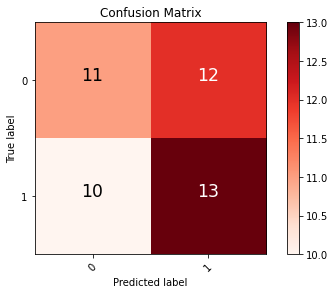

In [ ]:
#static files
n_epochs = 15
n_splits = 5
batch_size = 1
verbose = 2

accuracies = []
losses = []
trues = []
predicts = []

class_names = [0, 1]

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(static_nps, static_labels, static_groups):
  #split data into X and y training and test sets
  static_X_train, static_X_test = static_nps[train_index], static_nps[test_index]
  static_y_train, static_y_test = static_labels[train_index], static_labels[test_index]

  #build model
  model = create_model()
  
  #fit model
  history = model.fit(static_X_train, static_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(static_X_test, static_y_test))
  #evaluate model
  loss, accuracy = model.evaluate(static_X_test, static_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)

  y_true = static_y_test
  y_pred_prob = model.predict(static_X_test)
  y_pred = (y_pred_prob > 0.5) + 0

  trues.extend(y_true)
  predicts.extend(y_pred)

  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

Epoch 1/15
5/5 - 1s - loss: 0.7898 - accuracy: 0.4167 - val_loss: 0.6969 - val_accuracy: 0.3000
Epoch 2/15
5/5 - 0s - loss: 0.6199 - accuracy: 0.6111 - val_loss: 0.7083 - val_accuracy: 0.5000
Epoch 3/15
5/5 - 0s - loss: 0.5849 - accuracy: 0.5556 - val_loss: 0.7180 - val_accuracy: 0.5000
Epoch 4/15
5/5 - 0s - loss: 0.5307 - accuracy: 0.5556 - val_loss: 0.7312 - val_accuracy: 0.5000
Epoch 5/15
5/5 - 0s - loss: 0.4590 - accuracy: 0.8056 - val_loss: 0.7319 - val_accuracy: 0.5000
Epoch 6/15
5/5 - 0s - loss: 0.4071 - accuracy: 0.9444 - val_loss: 0.7090 - val_accuracy: 0.5000
Epoch 7/15
5/5 - 0s - loss: 0.3735 - accuracy: 0.9444 - val_loss: 0.6961 - val_accuracy: 0.5000
Epoch 8/15
5/5 - 0s - loss: 0.3198 - accuracy: 0.9722 - val_loss: 0.7215 - val_accuracy: 0.5000
Epoch 9/15
5/5 - 0s - loss: 0.3034 - accuracy: 0.9722 - val_loss: 0.7506 - val_accuracy: 0.5000
Epoch 10/15
5/5 - 0s - loss: 0.2063 - accuracy: 0.9444 - val_loss: 0.7631 - val_accuracy: 0.5000
Epoch 11/15
5/5 - 0s - loss: 0.1916 - a

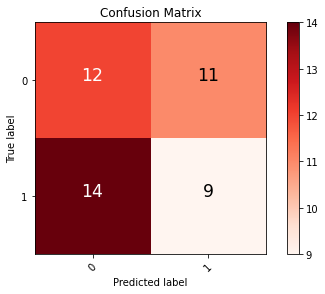

In [ ]:
#dynamic files
n_epochs = 15
n_splits = 5
batch_size = 8
verbose = 2

accuracies = []
losses = []
trues = []
predicts = []
class_names = [0, 1]

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(dyn_nps, dyn_labels, dyn_groups):
  #split data into X and y training and test sets
  dyn_X_train, dyn_X_test = dyn_nps[train_index], dyn_nps[test_index]
  dyn_y_train, dyn_y_test = dyn_labels[train_index], dyn_labels[test_index]

  #build model
  model = create_model()
  
  #fit model
  history = model.fit(dyn_X_train, dyn_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(dyn_X_test, dyn_y_test))
  #evaluate model
  loss, accuracy = model.evaluate(dyn_X_test, dyn_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)

  y_true = dyn_y_test
  y_pred_prob = model.predict(dyn_X_test)
  y_pred = (y_pred_prob > 0.5) + 0

  trues.extend(y_true)
  predicts.extend(y_pred)

  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Scale data**

In [ ]:
# Scale data
for i in range(static_nps.shape[0]):
    scaler = StandardScaler()
    static_nps[i, :, :] = scaler.fit_transform(static_nps[i, :, :]) 

print (static_nps.shape)

(46, 1101, 64)


In [ ]:
# Scale data
for i in range(dyn_nps.shape[0]):
    scaler = StandardScaler()
    dyn_nps[i, :, :] = scaler.fit_transform(dyn_nps[i, :, :]) 

print (dyn_nps.shape)

(46, 401, 64)


**Group K fold after scaling**

Epoch 1/15
36/36 - 3s - loss: 0.8409 - accuracy: 0.4167 - val_loss: 0.6812 - val_accuracy: 0.5000
Epoch 2/15
36/36 - 2s - loss: 0.7131 - accuracy: 0.5000 - val_loss: 0.6648 - val_accuracy: 0.8000
Epoch 3/15
36/36 - 2s - loss: 0.5905 - accuracy: 0.6111 - val_loss: 0.6742 - val_accuracy: 0.6000
Epoch 4/15
36/36 - 2s - loss: 0.5512 - accuracy: 0.6944 - val_loss: 0.6710 - val_accuracy: 0.5000
Epoch 5/15
36/36 - 2s - loss: 0.4314 - accuracy: 0.7778 - val_loss: 0.9083 - val_accuracy: 0.5000
Epoch 6/15
36/36 - 2s - loss: 0.4540 - accuracy: 0.8333 - val_loss: 0.8598 - val_accuracy: 0.6000
Epoch 7/15
36/36 - 2s - loss: 0.3505 - accuracy: 0.8889 - val_loss: 0.9647 - val_accuracy: 0.5000
Epoch 8/15
36/36 - 2s - loss: 0.2432 - accuracy: 0.8889 - val_loss: 1.0139 - val_accuracy: 0.5000
Epoch 9/15
36/36 - 2s - loss: 0.1755 - accuracy: 0.9444 - val_loss: 1.0151 - val_accuracy: 0.5000
Epoch 10/15
36/36 - 2s - loss: 0.1523 - accuracy: 0.9444 - val_loss: 1.6472 - val_accuracy: 0.5000
Epoch 11/15
36/36 -

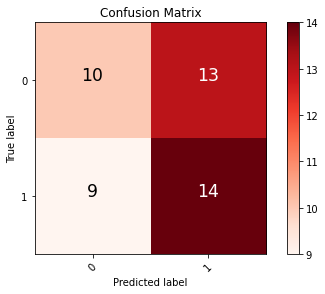

In [ ]:
#static files
n_epochs = 15
n_splits = 5
batch_size = 1
verbose = 2

accuracies = []
losses = []
trues = []
predicts = []

class_names = [0, 1]

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(static_nps, static_labels, static_groups):
  #split data into X and y training and test sets
  static_X_train, static_X_test = static_nps[train_index], static_nps[test_index]
  static_y_train, static_y_test = static_labels[train_index], static_labels[test_index]

  #build model
  model = create_model()
  
  #fit model
  history = model.fit(static_X_train, static_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(static_X_test, static_y_test))
  #evaluate model
  loss, accuracy = model.evaluate(static_X_test, static_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)

  y_true = static_y_test
  y_pred_prob = model.predict(static_X_test)
  y_pred = (y_pred_prob > 0.5) + 0

  trues.extend(y_true)
  predicts.extend(y_pred)

  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

Epoch 1/15
3/3 - 1s - loss: 0.6940 - accuracy: 0.4722 - val_loss: 0.6901 - val_accuracy: 0.4000
Epoch 2/15
3/3 - 0s - loss: 0.6333 - accuracy: 0.5000 - val_loss: 0.6845 - val_accuracy: 0.4000
Epoch 3/15
3/3 - 0s - loss: 0.5875 - accuracy: 0.5833 - val_loss: 0.6819 - val_accuracy: 0.5000
Epoch 4/15
3/3 - 0s - loss: 0.5326 - accuracy: 0.7778 - val_loss: 0.6846 - val_accuracy: 0.5000
Epoch 5/15
3/3 - 0s - loss: 0.5018 - accuracy: 0.7500 - val_loss: 0.6882 - val_accuracy: 0.5000
Epoch 6/15
3/3 - 0s - loss: 0.4596 - accuracy: 0.7222 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 7/15
3/3 - 0s - loss: 0.4282 - accuracy: 0.7778 - val_loss: 0.7051 - val_accuracy: 0.5000
Epoch 8/15
3/3 - 0s - loss: 0.3881 - accuracy: 0.8333 - val_loss: 0.7183 - val_accuracy: 0.6000
Epoch 9/15
3/3 - 0s - loss: 0.3271 - accuracy: 0.8611 - val_loss: 0.7389 - val_accuracy: 0.6000
Epoch 10/15
3/3 - 0s - loss: 0.3038 - accuracy: 0.9167 - val_loss: 0.7647 - val_accuracy: 0.6000
Epoch 11/15
3/3 - 0s - loss: 0.2726 - a

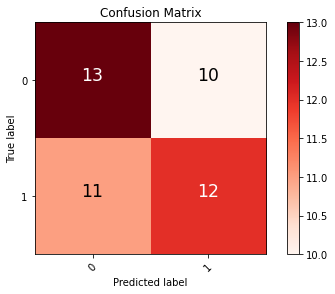

In [ ]:
#dynamic files
n_epochs = 15
n_splits = 5
batch_size = 16
verbose = 2

accuracies = []
losses = []
trues = []
predicts = []
class_names = [0, 1]

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(dyn_nps, dyn_labels, dyn_groups):
  #split data into X and y training and test sets
  dyn_X_train, dyn_X_test = dyn_nps[train_index], dyn_nps[test_index]
  dyn_y_train, dyn_y_test = dyn_labels[train_index], dyn_labels[test_index]

  #build model
  model = create_model()
  
  #fit model
  history = model.fit(dyn_X_train, dyn_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(dyn_X_test, dyn_y_test))
  #evaluate model
  loss, accuracy = model.evaluate(dyn_X_test, dyn_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)

  y_true = dyn_y_test
  y_pred_prob = model.predict(dyn_X_test)
  y_pred = (y_pred_prob > 0.5) + 0

  trues.extend(y_true)
  predicts.extend(y_pred)

  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')